In [1]:
import os
import sys
from datetime import datetime
import keras

import argparse
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD, Adamax
import keras.backend as K

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from func import * 

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# path = '/home/katieyth/gynecology/model_save/management/management_181225153555'
# path = '/home/katieyth/gynecology/model_save/UA/UA_181225153657'
# path = '/home/katieyth/gynecology/model_save/variability/variability_181225153624'
# path = '/home/katieyth/gynecology/model_save/deceleration/deceleration_181225153736'

path = '/home/katieyth/gynecology/model_save/multi/multi_190118211950' #0.98
# path = '/home/katieyth/gynecology/model_save/multi/multi_190119002910'







In [3]:
#### parser
parser = argparse.ArgumentParser()
parser.add_argument('-s' ,'--model_save', type=str, default='/home/katieyth/gynecology/model_save/', help='model save path')
parser.add_argument('-y' ,'--target', type=str, default='multi', help='prediction target')
parser.add_argument('-cv_path' ,'--cv_path', type=str, default='/home/katieyth/gynecology/data/5_fold_CTU_rs_13/', help='cv_path')

 
# input parameter
parser.add_argument('-th','--acceptable_zeros_threshold', type=float, default=200, help='acceptable number of missing values in raw data')
parser.add_argument('-l' ,'--length', type=int, default=600, help='length of input')
parser.add_argument('-ks','--k_slice', type=int, default=1, help='a input will be sliced into k_slice segments when testing')
parser.add_argument('-c' ,'--n_channel', type=int, default=2, help='number of input channels')
parser.add_argument('-rn','--random_noise', type=int, default=0, help='add Gaussian noise (mean=0, std=0.01) into inputs')
parser.add_argument('-nm','--normalized', type=int, default=1, help='whether conduct channel-wise normalization')

# data augmentation 
parser.add_argument('-aug_fliplr' ,'--aug_fliplr', type=int, default=0, help='reverse time series')
parser.add_argument('-shift' ,'--DA_Shift', type=int, default=1, help='')
parser.add_argument('-scale' ,'--DA_Scale', type=int, default=1, help='')
parser.add_argument('-randsamp' ,'--DA_RandSampling', type=int, default=1, help='')


# model parameters
parser.add_argument('-struc' ,'--struc', type=str, default='multi_task_FHB', help='deeper or shallower')
parser.add_argument('-k' ,'--kernel_size', type=int, default=3, help='kernel size')
parser.add_argument('-f' ,'--filters', type=int, default=64, help='base number of filters')
parser.add_argument('-ly' ,'--layers', type=int, default=5, help='number of residual layers')
parser.add_argument('-a' ,'--activation', type=str, default='relu', help='activation function')
parser.add_argument('-i' ,'--kernel_initializer', type=str, default='RandomNormal', help='kernel initialization method')
parser.add_argument('-l2','--l2', type=float, default=0.01, help='coefficient of l2 regularization')

# hyper-parameters
parser.add_argument('-lr','--learning_rate', type=float, default=1e-4, help='learning_rate')
parser.add_argument('-reduce_lr_patience','--reduce_lr_patience', type=int, default=50, help='reduce_lr_patience')
parser.add_argument('-bs','--batch_size', type=int, default=27, help='batch_size')
parser.add_argument('-ep','--epoch', type=int, default=15, help='epoch')
parser.add_argument('-wb','--weight_balance', type=int, default=1, help='whether weight balancing or not')
parser.add_argument('-mntr','--monitor', type=str, default='val_man_acc', help='val_acc or val_loss')

parser.add_argument('-g' ,'--gpu_id', type=str, default='2', help='GPU ID')
parser.add_argument('-fd' ,'--fold', type=int, default=5, help='fold')
parser.add_argument('-fn' ,'--summary_file', type=str, default='', help='summary filename')

FLAG = parser.parse_args([])
os.environ['CUDA_VISIBLE_DEVICES'] = FLAG.gpu_id

In [4]:
def data_preprocess_test(Xvalid, Yvalid, length=600):
    Xtest = np.empty((Xvalid.shape[0], length, Xvalid.shape[2]))
    for i in range(Xvalid.shape[0]):
        Xtest[i,:,:] = data_normalize(Xvalid[i,0:600,:])
    Ytest = Yvalid.copy()
    return Xtest, Ytest

In [5]:
### data preparing
train_d = pd.read_csv(os.path.join(FLAG.cv_path, '5_fold_0%s_train.csv' %(FLAG.fold)))
valid_d = pd.read_csv(os.path.join(FLAG.cv_path, '5_fold_0%s_test.csv' %(FLAG.fold)))

# replace 0 (no readings) with np.nan for later substitution
for k in train_d.columns:
    if 'b-' in k or 'm-' in k:
        print(k, end='\r')
        train_d.loc[train_d[k]==0, k] = np.nan
for k in valid_d.columns:
    if 'b-' in k or 'm-' in k:
        print(k, end='\r')
        valid_d.loc[valid_d[k]==0, k] = np.nan

    
# interpolate missing values
train_db = np.array(train_d[[k for k in train_d.columns if 'b-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
train_dm = np.array(train_d[[k for k in train_d.columns if 'm-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
valid_db = np.array(valid_d[[k for k in valid_d.columns if 'b-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
valid_dm = np.array(valid_d[[k for k in valid_d.columns if 'm-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
# combine signals from baby and mom
Xtrain = np.stack([train_db, train_dm], axis=2)
Xvalid = np.stack([valid_db, valid_dm], axis=2)

# convert labels to one-hot encodings
target_list = ['management', 'UA', 'variability', 'deceleration', 'FHB_class']
target_dict = {'management':3,
               'UA':2,
               'variability':2,
               'deceleration':4,
               'FHB_class':4}
Ytrain = [(keras.utils.to_categorical(np.array(train_d[c_name]),num_classes=target_dict[c_name])) for c_name in target_list]
Yvalid = [(keras.utils.to_categorical(np.array(valid_d[c_name]),num_classes=target_dict[c_name])) for c_name in target_list]

#weight balancing or not
if FLAG.weight_balance:
    weight_list = []
    for idx, c_name in enumerate(target_list):
        y_integers = np.argmax(Ytrain[idx], axis=1)
        d_class_weight = compute_class_weight('balanced', np.unique(y_integers), y_integers)
        class_weight = dict(enumerate(d_class_weight))
        print('class weight: {0}'.format(class_weight))
        weight_list.append(class_weight)
else:
    weight_list = []
    for idx, c_name in enumerate(target_list):
        class_weight = dict()
        for i in range(target_dict[c_name]):
            class_weight[i] = 1
        print('class weight: {0}'.format(class_weight))
        weight_list.append(class_weight)

Xtest, Ytest =data_preprocess_test(Xvalid, Yvalid)


if FLAG.aug_fliplr:
    Xtrain_copy = Xtrain.copy()
    for i in range(len(Xtrain)):
        Xtrain_copy[i] = np.fliplr([Xtrain[i]])[0]
        print(i,'/',len(Xtrain), end= '\r')
    Xtrain = np.vstack((Xtrain, Xtrain_copy))
    Ytrain = np.vstack((Ytrain, Ytrain))

print('train:', len(train_d))
print('test:', len(valid_d))

class weight: {0: 0.7183098591549296, 1: 1.146067415730337, 2: 1.36}
class weight: {0: 5.464285714285714, 1: 0.5503597122302158}
class weight: {0: 0.5257731958762887, 1: 10.2}
class weight: {0: 2.8333333333333335, 1: 4.5, 2: 0.298828125, 3: 12.75}
class weight: {0: 0.5503597122302158, 1: 5.464285714285714}
train: 306
test: 70


In [6]:
if FLAG.struc =='deeper':
    from model_multitask_more import build_model
elif FLAG.struc =='shallower':
    from model_multitask import build_model
elif FLAG.struc =='man_concat':
    from model_multitask_more_concat import build_model
elif FLAG.struc =='man_concat_shallower':
    from model_multitask_more_concat_shallower import build_model
elif FLAG.struc =='mimic_previous':
    from model_multitask_more_concat_mimic_previous import build_model
elif FLAG.struc =='mimic_previous_FHB':
    from model_multitask_more_concat_mimic_previous_FHB import build_model
elif FLAG.struc =='multi_task_FHB':
    from model_multitask_more_FHB import build_model

In [7]:
# evaluate by trained model
trained_model = load_model(os.path.join(path,'model.h5'))
Pred = trained_model.predict(Xtest)

# test model performance

management accuracy :  0.38571428571428573
management_recall-0 : 0.5758
management_recall-1 : 0.3500
management_recall-2 : 0.0588
management_recall-average : 0.3282
management_precision-0: 0.4750
management_precision-1: 0.2500
management_precision-2: 0.5000
management_precision-average : 0.4083
management_F1-0: 0.5205
management_F1-1: 0.2917
management_F1-2: 0.1053
management_F1-average : 0.3058
Confusion matrix, without normalization
[[19 14  0]
 [12  7  1]
 [ 9  7  1]]
UA accuracy :  0.9
UA_recall-0 : 0.2000
UA_recall-1 : 0.9538
UA_recall-average : 0.5769
UA_precision-0: 0.2500
UA_precision-1: 0.9394
UA_precision-average : 0.5947
UA_F1-0: 0.2222
UA_F1-1: 0.9466
UA_F1-average : 0.5844
Confusion matrix, without normalization
[[ 1  4]
 [ 3 62]]
variability accuracy :  0.9714285714285714
variability_recall-0 : 0.9855
variability_recall-1 : 0.0000
variability_recall-average : 0.4928
variability_precision-0: 0.9855
variability_precision-1: 0.0000
variability_precision-average : 0.4928
vari

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


management_2_F1-1: 0.4776
management_2_F1-average : 0.4991
Confusion matrix, without normalization
[[19 14]
 [21 16]]


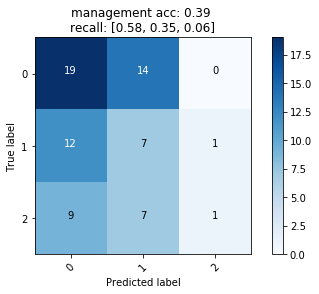

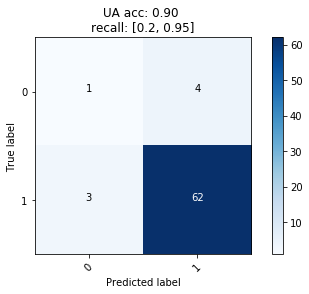

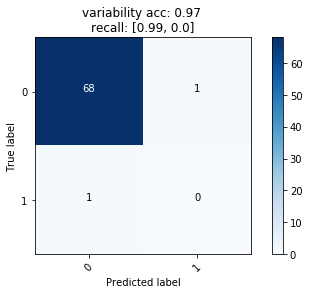

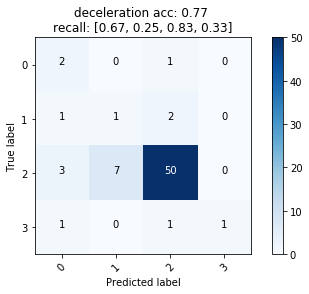

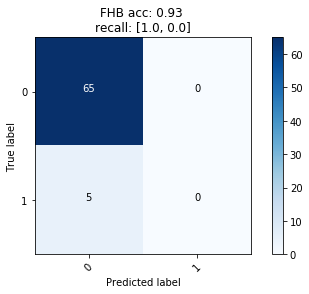

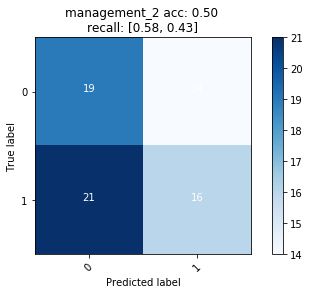

In [8]:
c_list = ['management', 'UA', 'variability', 'deceleration', 'FHB']
for c in range(len(c_list)):
    ypred_aug = np.argmax(Pred[c] , axis=1)
    ytest_aug = np.argmax(Ytest[c], axis=1)

    cfm = confusion_matrix(y_pred=ypred_aug, y_true=ytest_aug)
    recall = np.diag(cfm) / np.sum(cfm, axis=1)
    precision = np.diag(cfm) / np.sum(cfm, axis=0)
    val_accu = accuracy_score(y_pred=ypred_aug, y_true=ytest_aug)
    f1 = f1_score(y_pred=ypred_aug, y_true=ytest_aug, average=None)
#         _val_recall = recall_score(val_targ, val_predict, average=None)
#         _val_precision = precision_score(val_targ, val_predict, average=None)
    
    

    print('%s accuracy : ' % (c_list[c]), val_accu)
    tmp_list = []
    for i in range(len(recall)):
        print('%s_recall-%d : %.4f' %(c_list[c],i, recall[i]))
        tmp_list.append(recall[i])
    print('%s_recall-average : %.4f' %(c_list[c], sum(tmp_list)/len(tmp_list)))
    
    tmp_list = []
    for i in range(len(precision)):
        print('%s_precision-%d: %.4f' % (c_list[c],i, precision[i]))
        tmp_list.append(precision[i])
    print('%s_precision-average : %.4f' %(c_list[c], sum(tmp_list)/len(tmp_list)))
    
    tmp_list = []
    for i in range(len(f1)):
        print('%s_F1-%d: %.4f' % (c_list[c],i, f1[i]))
        tmp_list.append(f1[i])
    print('%s_F1-average : %.4f' %(c_list[c], sum(tmp_list)/len(tmp_list)))
    

    plt.figure()
    rcl = [round(recall[i],2) for i in range(len(recall))]
    plot_confusion_matrix(cfm, classes=np.arange(len(recall)),
                          title='%s acc: %.2f \nrecall: %s' %(c_list[c], val_accu,rcl),
                          save_dir='' )
# force management to 2 label 
c_list = ['management_2']
for idx, c in enumerate([0]):
    # evaluate by every segment
    ypred_aug = np.argmax(Pred[c] , axis=1)
    ytest_aug = np.argmax(Ytest[c], axis=1)
    ypred_aug[ypred_aug>1]=1
    ytest_aug[ytest_aug>1]=1

    cfm = confusion_matrix(y_pred=ypred_aug, y_true=ytest_aug)
    recall = np.diag(cfm) / np.sum(cfm, axis=1)
    precision = np.diag(cfm) / np.sum(cfm, axis=0)
    val_accu = accuracy_score(y_pred=ypred_aug, y_true=ytest_aug)
    f1 = f1_score(y_pred=ypred_aug, y_true=ytest_aug, average=None)
    
    tmp_list = []
    for i in range(len(recall)):
        print('%s_recall-%d : %.4f' %(c_list[idx],i, recall[i]))
        tmp_list.append(recall[i])
    print('%s_recall-average : %.4f' %(c_list[idx], sum(tmp_list)/len(tmp_list)))
    
    tmp_list = []
    for i in range(len(precision)):
        print('%s_precision-%d: %.4f' % (c_list[idx],i, precision[i]))
        tmp_list.append(precision[i])
    print('%s_precision-average : %.4f' %(c_list[idx], sum(tmp_list)/len(tmp_list)))
    
    tmp_list = []
    for i in range(len(f1)):
        print('%s_F1-%d: %.4f' % (c_list[idx],i, f1[i]))
        tmp_list.append(f1[i])
    print('%s_F1-average : %.4f' %(c_list[idx], sum(tmp_list)/len(tmp_list)))
    

    plt.figure()
    rcl = [round(recall[i],2) for i in range(len(recall))]
    plot_confusion_matrix(cfm, classes=np.arange(len(recall)), 
                          title='%s acc: %.2f \nrecall: %s' %(c_list[idx], val_accu,rcl),
                          save_dir='' )


In [9]:
def plot_keras_csv_logger(csv_logger, save_dir='', accuracy=False, gradient=False):
    if type(csv_logger) is str:
        loss = pd.read_table(csv_logger, delimiter=',')
    else:
        loss = pd.read_table(csv_logger.filename, delimiter=',')
    print('min val_loss {0} at epoch {1}'.format(min(loss.val_loss), np.argmin(loss.val_loss)))
    plt.plot(loss.epoch, loss.loss, label='loss')
    plt.plot(loss.epoch, loss.val_loss, label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig(os.path.join(save_dir, 'loss.png'))
    plt.show()
    plt.close()

    if accuracy:
        print('max val_accu {0} at epoch {1}'.format(max(loss.val_dec_acc), np.argmax(loss.val_dec_acc)))
        plt.plot(loss.epoch, loss.dec_acc, label='dec_acc')
        plt.plot(loss.epoch, loss.val_dec_acc, label='val_dec_acc')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.savefig(os.path.join(save_dir, 'dec_acc.png'))
        plt.show()
        plt.close()
        
        print('max val_accu {0} at epoch {1}'.format(max(loss.val_var_acc), np.argmax(loss.val_var_acc)))
        plt.plot(loss.epoch, loss.var_acc, label='var_acc')
        plt.plot(loss.epoch, loss.val_var_acc, label='val_var_acc')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.savefig(os.path.join(save_dir, 'var_acc.png'))
        plt.show()
        plt.close()
        
        print('max val_accu {0} at epoch {1}'.format(max(loss.val_ua_acc), np.argmax(loss.val_ua_acc)))
        plt.plot(loss.epoch, loss.ua_acc, label='ua_acc')
        plt.plot(loss.epoch, loss.val_ua_acc, label='val_ua_acc')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.savefig(os.path.join(save_dir, 'ua_acc.png'))
        plt.show()
        plt.close()
        
        print('max val_accu {0} at epoch {1}'.format(max(loss.val_man_acc), np.argmax(loss.val_man_acc)))
        plt.plot(loss.epoch, loss.man_acc, label='man_acc')
        plt.plot(loss.epoch, loss.val_man_acc, label='val_man_acc')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.savefig(os.path.join(save_dir, 'man_acc.png'))
        plt.show()
        plt.close()
       
    if gradient:
        plt.plot(loss.epoch, loss.gradient_norm, label='gradient_norm')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('gradient_norm')
        plt.savefig(os.path.join(save_dir, 'gradient.png'))
        plt.show()
        plt.close()

In [10]:
# # plot learning curve
# plot_keras_csv_logger(os.path.join(path,'training.log'), save_dir=path, accuracy=True, gradient = True)

# feature analysis

In [11]:
tg_order = 0
tg_name = 'management'

In [12]:
pred_hd_l = np.argmax(Pred[tg_order], axis=1)
valid_d.reset_index(inplace=True)
pred_dataset = valid_d['ID']

In [13]:
cmu_id = [i for i, e in enumerate(valid_d['ID']) if 'CMU_' in e]
ctu_id = [i for i, e in enumerate(valid_d['ID']) if 'CTU_' in e]

In [14]:
features = trained_model.get_layer('global_average_pooling1d_1')
extractor = Model(inputs=trained_model.input, outputs=features.output)
Fout = extractor.predict(x=Xtest)

In [15]:
O_X = valid_d[tg_name] == pred_hd_l
print('Wrong Prediction:', len(O_X)-sum(O_X))
print('Acc:', sum(O_X)/len(O_X))
# O_X[O_X==1] = 'gray'
# O_X[O_X==0] = 'red'

Wrong Prediction: 43
Acc: 0.38571428571428573


In [16]:
def get_color_map(ref_list):
    color_map=[]
    for i in ref_list:
        if i ==0:
            color_map.append('orange')
        elif i==1:
            color_map.append('blue')
        elif i==2:
            color_map.append('green')
        elif i==3:
            color_map.append('red')
    color_map = np.array(color_map)
    return color_map

In [17]:
def get_color_map_OX(ref_list):
    color_map=[]
    for i in ref_list:
        if i ==0:
            color_map.append('red')
        elif i==1:
            color_map.append('gray')
    color_map = np.array(color_map)
    return color_map

## PCA

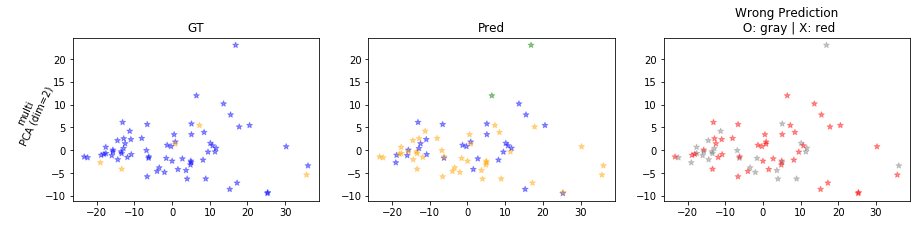

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_emb = pca.fit_transform(Fout)


fig = plt.figure(figsize=(15,3))
plt.subplot('13%s' % (1))
color_map = get_color_map(valid_d['UA'])
plt.scatter(pca_emb[cmu_id,0], pca_emb[cmu_id,1], c = color_map[cmu_id], marker='o', cmap='coolwarm', alpha=0.4)
plt.scatter(pca_emb[ctu_id,0], pca_emb[ctu_id,1], c = color_map[ctu_id], marker='*', cmap='coolwarm', alpha=0.4)
plt.ylabel('%s\n PCA (dim=2)' %(FLAG.target), rotation=65)
plt.title('GT')

plt.subplot('13%s' % (2))
color_map = get_color_map(pred_hd_l)
plt.scatter(pca_emb[cmu_id,0], pca_emb[cmu_id,1], c = color_map[cmu_id], marker='o', cmap='cool', alpha=0.4)
plt.scatter(pca_emb[ctu_id,0], pca_emb[ctu_id,1], c = color_map[ctu_id], marker='*', cmap='cool', alpha=0.4)
plt.title('Pred')

plt.subplot('13%s' % (3))
color_map = get_color_map_OX(O_X)
plt.scatter(pca_emb[cmu_id,0], pca_emb[cmu_id,1], c = color_map[cmu_id], marker='o', alpha=0.4)
plt.scatter(pca_emb[ctu_id,0], pca_emb[ctu_id,1], c = color_map[ctu_id], marker='*', alpha=0.4)
plt.title('Wrong Prediction\n O: gray | X: red')
# plt.show()

# # check_dir('./plot/feature_analysis/')
fig.savefig(os.path.join(path, 'F_analysis_pca_%s.png') % (FLAG.target), dpi=100, format='png',bbox_inches='tight' )

## TSNE

In [19]:
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, perplexity=50)
# tsne_emb = tsne.fit_transform(Fout)

# fig = plt.figure(figsize=(15,3))
# plt.subplot('13%s' % (1))
# color_map = get_color_map(valid_d[FLAG.target])
# plt.scatter(tsne_emb[cmu_id,0], tsne_emb[cmu_id,1], c = color_map[cmu_id], marker='o', cmap='coolwarm', alpha=0.4)
# plt.scatter(tsne_emb[ctu_id,0], tsne_emb[ctu_id,1], c = color_map[ctu_id], marker='*', cmap='coolwarm', alpha=0.4)
# plt.ylabel('%s\n TSNE (dim=2)' %(FLAG.target), rotation=65)
# plt.title('GT')

# plt.subplot('13%s' % (2))
# color_map = get_color_map(pred_hd_l)
# plt.scatter(tsne_emb[cmu_id,0], tsne_emb[cmu_id,1], c = color_map[cmu_id], marker='o', cmap='cool', alpha=0.4)
# plt.scatter(tsne_emb[ctu_id,0], tsne_emb[ctu_id,1], c = color_map[ctu_id], marker='*', cmap='cool', alpha=0.4)
# plt.title('Pred')

# plt.subplot('13%s' % (3))
# color_map = get_color_map_OX(O_X)
# plt.scatter(tsne_emb[cmu_id,0], tsne_emb[cmu_id,1], c = color_map[cmu_id], marker='o', alpha=0.4)
# plt.scatter(tsne_emb[ctu_id,0], tsne_emb[ctu_id,1], c = color_map[ctu_id], marker='*', alpha=0.4)
# plt.title('Wrong Prediction\n O: gray | X: red')
# # plt.show()

# # # check_dir('./plot/feature_analysis/')
# fig.savefig(os.path.join(path, 'F_analysis_tsne_%s.png') % (FLAG.target), dpi=100, format='png',bbox_inches='tight' )

# SVM

In [20]:
# Fout_train = extractor.predict(x=Xtrain)
# pca_emb_train = pca.fit_transform(Fout_train)
# Ytrain_N1hot = np.argmax(Ytrain,axis=1)
# Ytest_N1hot = np.argmax(Ytest,axis=1)

# from sklearn.svm import SVC
# svc = SVC(kernel='rbf', verbose= True, gamma = 1e-1)
# svc.fit(Fout_train, Ytrain_N1hot)

# svc_pred = svc.predict(Fout)

# # from mlxtend.plotting import plot_decision_regions
# # plot_decision_regions(X=pca_emb_train, y=Ytrain_N1hot, clf=svc)

# # from mlxtend.plotting import plot_decision_regions
# # plot_decision_regions(X=pca_emb, y=Ytest_N1hot, clf=svc)

# # evaluate validation set
# cfm = confusion_matrix(y_pred=svc_pred, y_true=Ytest_N1hot)

# recall = np.diag(cfm) / np.sum(cfm, axis=1)
# precision = np.diag(cfm) / np.sum(cfm, axis=0)
# val_accu = accuracy_score(y_pred=svc_pred, y_true=Ytest_N1hot)

# print('accuracy : ', round(val_accu,4))
# for i in range(n_classes):
#     print('recall-{0} : {1}'.format(i, round(recall[i],4)))
# for i in range(n_classes):
#     print('precision-{0}: {1}'.format(i, round(precision[i],4)))
    
# plt.figure()
# rcl = [round(recall[i],2) for i in range(n_classes)]
# plot_confusion_matrix(cfm, classes=np.arange(n_classes),
#                       title='%s acc: %.2f \nrecall: %s' %(FLAG.target, val_accu, rcl),
#                      )#save_dir=path)